# IDS

## Imports

In [27]:
import glob
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

## Load data

In [28]:
DATASET_DIRECTORY = "./CICIoT2023/"

In [29]:
def sample_rows(
    df: pd.core.frame.DataFrame, percent_rows: float
) -> pd.core.frame.DataFrame:
    dfs = []
    for label, df in df.groupby("label"):
        dfs.append(df.sample(frac=percent_rows))

    return pd.concat(dfs, ignore_index=True).sample(frac=1)


def load_data(file_list: list, percentage: float) -> pd.core.frame.DataFrame:
    dataframes = []
    for file in file_list:
        file_path = os.path.join(file)
        df = pd.read_csv(file_path)
        dataframes.append(sample_rows(df=df, percent_rows=percentage))
    return pd.concat(dataframes)

In [30]:
df_sets = sorted(glob.glob(os.path.join(DATASET_DIRECTORY, "*.csv")))

training_data, test_data = train_test_split(
    load_data(file_list=df_sets, percentage=0.001), test_size=0.2, random_state=42
)

## X and Y columns

### 33 Classifiers

In [31]:
X_columns = [
    "flow_duration",
    "Header_Length",
    "Protocol Type",
    "Duration",
    "Rate",
    "Srate",
    "Drate",
    "fin_flag_number",
    "syn_flag_number",
    "rst_flag_number",
    "psh_flag_number",
    "ack_flag_number",
    "ece_flag_number",
    "cwr_flag_number",
    "ack_count",
    "syn_count",
    "fin_count",
    "urg_count",
    "rst_count",
    "HTTP",
    "HTTPS",
    "DNS",
    "Telnet",
    "SMTP",
    "SSH",
    "IRC",
    "TCP",
    "UDP",
    "DHCP",
    "ARP",
    "ICMP",
    "IPv",
    "LLC",
    "Tot sum",
    "Min",
    "Max",
    "AVG",
    "Std",
    "Tot size",
    "IAT",
    "Number",
    "Magnitue",
    "Radius",
    "Covariance",
    "Variance",
    "Weight",
]
y_column = "label"

### 8 Classifiers

In [32]:
eight_classes = {}

eight_classes["BenignTraffic"] = "Benign"

eight_classes["DDoS-RSTFINFlood"] = "DDoS"
eight_classes["DDoS-PSHACK_Flood"] = "DDoS"
eight_classes["DDoS-SYN_Flood"] = "DDoS"
eight_classes["DDoS-UDP_Flood"] = "DDoS"
eight_classes["DDoS-TCP_Flood"] = "DDoS"
eight_classes["DDoS-ICMP_Flood"] = "DDoS"
eight_classes["DDoS-SynonymousIP_Flood"] = "DDoS"
eight_classes["DDoS-ACK_Fragmentation"] = "DDoS"
eight_classes["DDoS-UDP_Fragmentation"] = "DDoS"
eight_classes["DDoS-ICMP_Fragmentation"] = "DDoS"
eight_classes["DDoS-SlowLoris"] = "DDoS"
eight_classes["DDoS-HTTP_Flood"] = "DDoS"

eight_classes["DoS-UDP_Flood"] = "DoS"
eight_classes["DoS-SYN_Flood"] = "DoS"
eight_classes["DoS-TCP_Flood"] = "DoS"
eight_classes["DoS-HTTP_Flood"] = "DoS"

eight_classes["Mirai-greeth_flood"] = "Mirai"
eight_classes["Mirai-greip_flood"] = "Mirai"
eight_classes["Mirai-udpplain"] = "Mirai"

eight_classes["Recon-PingSweep"] = "Recon"
eight_classes["Recon-OSScan"] = "Recon"
eight_classes["Recon-PortScan"] = "Recon"
eight_classes["VulnerabilityScan"] = "Recon"
eight_classes["Recon-HostDiscovery"] = "Recon"

eight_classes["DNS_Spoofing"] = "Spoofing"
eight_classes["MITM-ArpSpoofing"] = "Spoofing"

eight_classes["BrowserHijacking"] = "Web"
eight_classes["Backdoor_Malware"] = "Web"
eight_classes["XSS"] = "Web"
eight_classes["Uploading_Attack"] = "Web"
eight_classes["SqlInjection"] = "Web"
eight_classes["CommandInjection"] = "Web"

eight_classes["DictionaryBruteForce"] = "BruteForce"

### Columns

In [33]:
training_data[y_column] = [eight_classes[c] for c in training_data[y_column]]
test_data[y_column] = [eight_classes[c] for c in test_data[y_column]]

X_train = training_data[X_columns]
y_train = training_data[y_column]
X_test = test_data[X_columns]
y_test = test_data[y_column]

## Scaling

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Models

In [35]:
k_nearest_neighbors = KNeighborsClassifier()
support_vector_classification = SVC()
logistic_regression = LogisticRegression(n_jobs=-1, max_iter=10000)
gaussian_naive_bayes = GaussianNB()
random_forest = RandomForestClassifier()

In [36]:
def save_results(results: dict):
    df = pd.DataFrame(results)

    file_path = f"./results.csv"
    file_dir = os.path.dirname(file_path)

    if not os.path.exists(file_dir):
        os.makedirs(file_dir)

    if not os.path.isfile(file_path):
        df.to_csv(file_path, index=False)

    df.to_csv(file_path, mode="a", index=False, header=False)


def evaluate_model(model, X_train, y_train, X_test, y_test):
    start_training = time.time()
    model.fit(X_train, y_train)
    end_training = time.time()

    start_testing = time.time()
    y_pred = model.predict(X_test)
    end_testing = time.time()

    plt.figure(figsize=(4, 2), dpi=250)
    ConfusionMatrixDisplay(
        np.round(
            confusion_matrix(y_test, y_pred, labels=y_test.unique(), normalize="true"),
            2,
        ),
        display_labels=y_test.unique(),
    ).plot()
    plt.xticks(rotation=90)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")

    save_results(
        [
            {
                "model": type(model).__name__,
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "train_num_rows": len(X_train),
                "test_num_rows": len(X_test),
                "duration_training": float(f"{end_training - start_training:.4f}"),
                "duration_testing": float(f"{end_testing - start_testing:.4f}"),
            }
        ]
    )

<Figure size 1000x500 with 0 Axes>

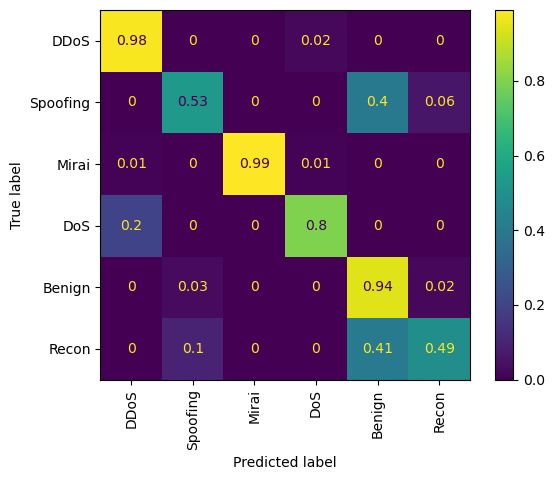

In [37]:
evaluate_model(k_nearest_neighbors, X_train_scaled, y_train, X_test_scaled, y_test)

<Figure size 1000x500 with 0 Axes>

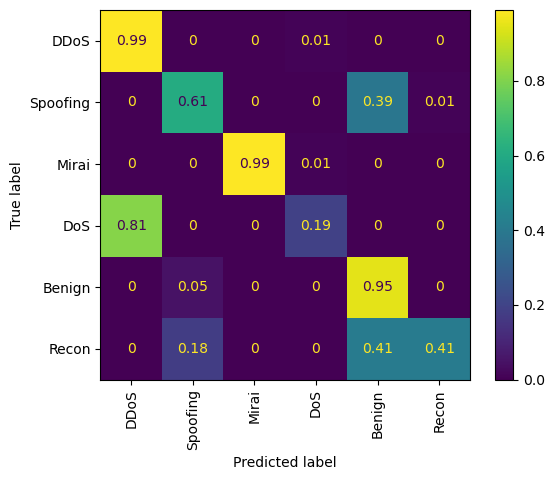

In [38]:
evaluate_model(support_vector_classification, X_train_scaled, y_train, X_test_scaled, y_test)

<Figure size 1000x500 with 0 Axes>

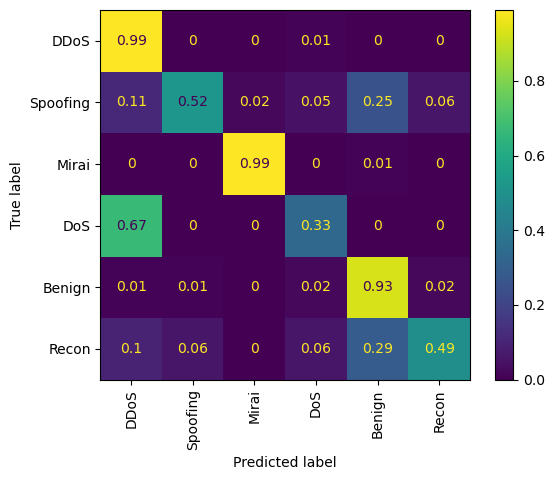

In [39]:
evaluate_model(logistic_regression, X_train_scaled, y_train, X_test_scaled, y_test)

<Figure size 1000x500 with 0 Axes>

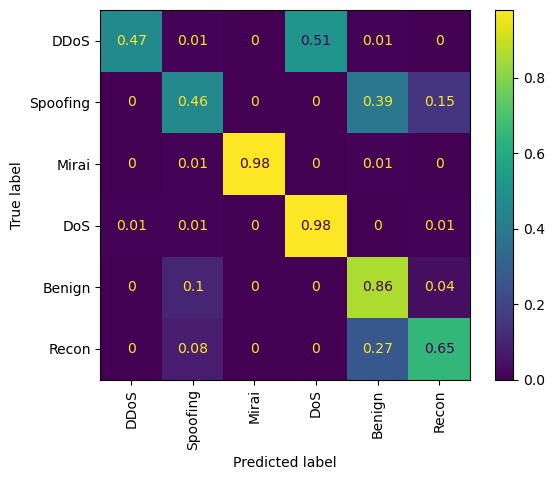

In [40]:
evaluate_model(gaussian_naive_bayes, X_train_scaled, y_train, X_test_scaled, y_test)

<Figure size 1000x500 with 0 Axes>

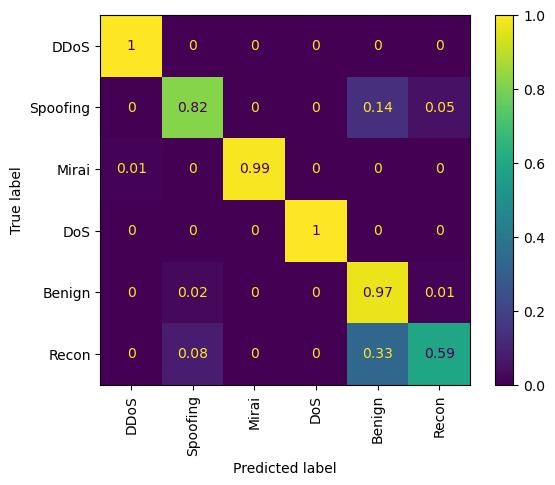

In [41]:
evaluate_model(random_forest, X_train_scaled, y_train, X_test_scaled, y_test)

# Results

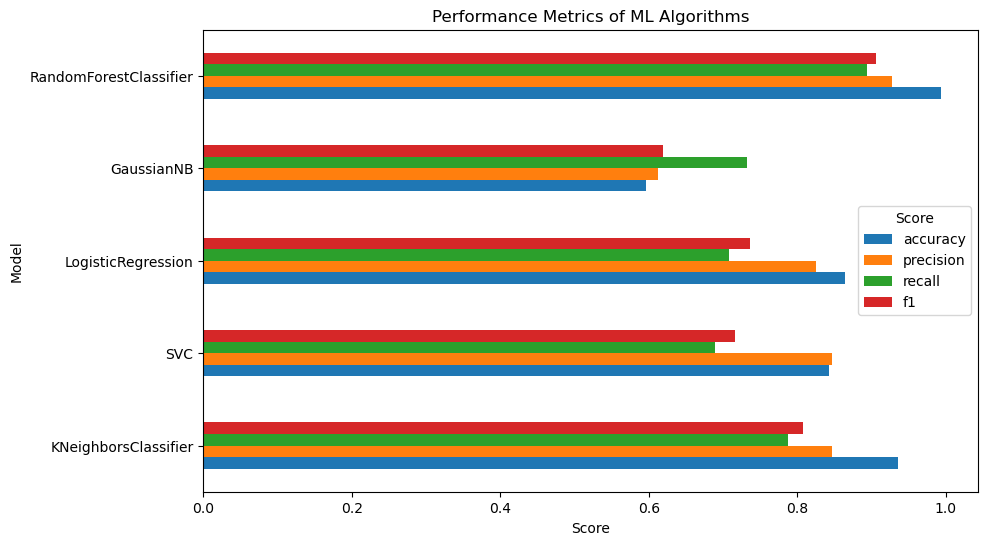

In [43]:
df = pd.read_csv("./results.csv")
df.set_index("model", inplace=True)
df.drop_duplicates(inplace=True)

df[["accuracy", "precision", "recall", "f1"]].plot(kind="barh", figsize=(10, 6))
plt.title("Performance Metrics of ML Algorithms")
plt.xlabel("Score")
plt.ylabel("Model")
plt.legend(title="Score")
plt.show()